In [1]:
!pip install --quiet torch>=1.10.0 torchvision>=0.11.0 pytorch-lightning==1.7.1 torchmetrics==0.9.3 timm optuna==2.10.1


In [2]:
from typing import Any, Dict, Optional, Tuple, List

import argparse
import os
from typing import List
from typing import Optional

import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.trial import TrialState

import os
import subprocess
import torch
import timm
import json

import pytorch_lightning as pl
import torchvision.transforms as T
import torch.nn.functional as F

from pathlib import Path
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from torchmetrics.functional import accuracy
from torchmetrics import F1Score, Precision, Recall, ConfusionMatrix, MaxMetric, MeanMetric
from torchmetrics.classification.accuracy import Accuracy
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import TQDMProgressBar
from torch.optim.lr_scheduler import OneCycleLR
from packaging import version
import torch.optim as optim
from datetime import datetime

In [3]:
if version.parse(pl.__version__) < version.parse("1.0.2"):
    raise RuntimeError("PyTorch Lightning>=1.0.2 is required for this example.")

PERCENT_VALID_EXAMPLES = 0.1
BATCHSIZE = 64
CLASSES = 6
EPOCHS = 5
DIR = "/kaggle/input/intel-image-classification"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class LitResnet(pl.LightningModule):

    def __init__(
            self,
            model_name='resnet18',
            optim_name="SGD",
            num_classes=6,
            lr=0.001,
    ):
        super().__init__()

        # this line allows to access init params with 'self.hparams' attribute
        # also ensures init params will be stored in ckpt
        self.save_hyperparameters(logger=False, ignore=["net"])

        self.num_classes = num_classes

        self.net = timm.create_model(model_name, pretrained=True, num_classes=self.num_classes)
        self.lr = lr
        # configure optimizer
        if optim_name == "ADAM":
            self.optim_name = torch.optim.Adam
        if optim_name == "SGD":
            self.optim_name = torch.optim.SGD
        if optim_name == "RMS":
            self.optim_name = torch.optim.RMSprop

        # for averaging loss across batches
        self.train_loss = MeanMetric()
        self.val_loss = MeanMetric()
        self.test_loss = MeanMetric()

        # loss function
        self.criterion = torch.nn.CrossEntropyLoss()

        # for tracking best so far validation accuracy
        self.val_acc_best = MaxMetric()

        # metric objects for calculating and averaging accuracy across batches
        self.train_acc = Accuracy(task='multiclass', num_classes=self.num_classes)
        self.val_acc = Accuracy(task='multiclass', num_classes=self.num_classes)
        self.test_acc = Accuracy(task='multiclass', num_classes=self.num_classes)

        # some other metrics to be logged
        self.f1_score = F1Score(task="multiclass", num_classes=self.num_classes)
        self.precision_score = Precision(task="multiclass", average='macro', num_classes=self.num_classes)
        self.recall_score = Recall(task="multiclass", average='macro', num_classes=self.num_classes)

    def forward(self, x: torch.Tensor):
        return self.net(x)

    def step(self, batch: Any):
        x, y = batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        return loss, preds, y

    def training_step(self, batch: Any, batch_idx: int):
        loss, preds, targets = self.step(batch)

        # update and log metrics
        self.train_loss(loss)
        self.train_acc(preds, targets)
        self.log("train/loss", self.train_loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train/acc", self.train_acc, on_step=True, on_epoch=True, prog_bar=True)

        # we can return here dict with any tensors
        # and then read it in some callback or in `training_epoch_end()` below
        # remember to always return loss from `training_step()` or backpropagation will fail!
        return {"loss": loss, "preds": preds, "targets": targets}

    def training_epoch_end(self, outputs: List[Any]):
        # `outputs` is a list of dicts returned from `training_step()`
        pass

    def validation_step(self, batch: Any, batch_idx: int):
        loss, preds, targets = self.step(batch)

        # update and log metrics
        self.val_loss(loss)
        self.val_acc(preds, targets)
        self.f1_score(preds, targets)
        self.precision_score(preds, targets)
        self.recall_score(preds, targets)
        self.log("val/loss", self.val_loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("val/acc", self.val_acc, on_step=True, on_epoch=True, prog_bar=False)
        self.log("val/f1", self.val_acc, on_step=False, on_epoch=True, prog_bar=False)
        self.log("val/precision", self.precision_score, on_step=False, on_epoch=True, prog_bar=False)
        self.log("val/recall", self.recall_score, on_step=False, on_epoch=True, prog_bar=False)
        return {"loss": loss, "preds": preds, "targets": targets}

    def validation_epoch_end(self, outs: List[Any]):
        acc = self.val_acc.compute()  # get current val acc
        self.val_acc_best(acc)  # update best so far val acc
        # log `val_acc_best` as a value through `.compute()` method, instead of as a metric object
        # otherwise metric would be reset by lightning after each epoch
        self.log("val/acc_best", self.val_acc_best.compute(), on_step=False, on_epoch=True, prog_bar=False)

    def test_step(self, batch: Any, batch_idx: int):
        loss, preds, targets = self.step(batch)

        # update and log metrics
        self.test_loss(loss)
        self.test_acc(preds, targets)
        self.log("test/loss", self.test_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test/acc", self.test_acc, on_step=False, on_epoch=True, prog_bar=True)

        return {"loss": loss, "preds": preds, "targets": targets}

    def test_epoch_end(self, outputs: List[Any]):
        pass

    def configure_optimizers(self):
        optimizer = self.optim_name(
            self.parameters(),
            lr=self.lr,
        )
#         steps_per_epoch = 45000 // BATCHSIZE
        sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size  = 10 , gamma = 0.5)
        return {
            "optimizer":optimizer,
            "lr_scheduler" : {
                "scheduler" : sch,
                "monitor" : "train/loss",
                
            }
          }
#         scheduler_dict = {
#             "scheduler": OneCycleLR(
#                 optimizer,
#                 0.1,
#                 epochs=self.trainer.max_epochs,
#                 steps_per_epoch=steps_per_epoch,
#             ),
#             "interval": "step",
#         }
#         return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}
          


In [5]:
class IntelClassificationDataModule(pl.LightningDataModule):
    def __init__(
            self,
            data_dir: str = "dataset/",
            batch_size: int = 256,
            num_workers: int = 4,
            pin_memory: bool = False,
    ):
        super().__init__()

        # this line allows to access init params with 'self.hparams' attribute
        # also ensures init params will be stored in ckpt
        self.save_hyperparameters(logger=False)

        self.data_dir = Path(data_dir)

        # data transformations
        self.transforms = T.Compose([
            T.RandomRotation(degrees=66),
            T.RandomHorizontalFlip(p=0.5),
            T.ColorJitter(brightness=(0.1,0.6), contrast=1,saturation=0, hue=0.4),
            T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
            T.Resize((224, 224)),
            T.RandomCrop(size=(128, 128)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        self.data_train: Optional[Dataset] = None
        self.data_test: Optional[Dataset] = None

    @property
    def num_classes(self):
        return len(self.data_train.classes)

    @property
    def classes(self):
        return self.data_train.classes

    def prepare_data(self):
        """Download data if needed.
        Do not use it to assign state (self.x = y).
        """
        pass

    def setup(self, stage: Optional[str] = None):
        """Load data. Set variables: `self.data_train`, `self.data_val`, `self.data_test`.
        This method is called by lightning with both `trainer.fit()` and `trainer.test()`, so be
        careful not to execute things like random split twice!
        """
        # load and split datasets only if not loaded already
        if not self.data_train and not self.data_test:
            trainset = ImageFolder(self.data_dir / "seg_train" / "seg_train", transform=self.transforms)
            testset = ImageFolder(self.data_dir / "seg_test" / "seg_test", transform=self.transforms)

            self.data_train, self.data_test = trainset, testset

    def train_dataloader(self):
        return DataLoader(
            dataset=self.data_train,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.data_test,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=False,
        )

    def test_dataloader(self):
        return DataLoader(
            dataset=self.data_test,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=False,
        )

    def teardown(self, stage: Optional[str] = None):
        """Clean up after fit or test."""
        pass

    def state_dict(self):
        """Extra things to save to checkpoint."""
        return {}

    def load_state_dict(self, state_dict: Dict[str, Any]):
        """Things to do when loading checkpoint."""
        pass


Lr Finder Reference:: https://github.com/mtszkw/lightning-lr-find/blob/master/lightning_lr_find.ipynb 

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-attn-weights/regnetz_c_rab2_256-a54bf36a.pth" to /root/.cache/torch/hub/checkpoints/regnetz_c_rab2_256-a54bf36a.pth
/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

#########################
Auto-find model LR is:
 [Model Name: regnetz_c16, Optimizer Name: ADAM, Best Lr: 0.0019054607179632484 ]
#############################


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

#########################
Auto-find model LR is:
 [Model Name: regnetz_c16, Optimizer Name: SGD, Best Lr: 0.47863009232263803 ]
#############################


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

#########################
Auto-find model LR is:
 [Model Name: regnetz_c16, Optimizer Name: RMS, Best Lr: 0.0005248074602497723 ]
#############################


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

#########################
Auto-find model LR is:
 [Model Name: resnet18, Optimizer Name: ADAM, Best Lr: 0.0003019951720402019 ]
#############################


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

#########################
Auto-find model LR is:
 [Model Name: resnet18, Optimizer Name: SGD, Best Lr: 0.030199517204020192 ]
#############################


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

#########################
Auto-find model LR is:
 [Model Name: resnet18, Optimizer Name: RMS, Best Lr: 0.0002089296130854041 ]
#############################


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

#########################
Auto-find model LR is:
 [Model Name: efficientnet_b0, Optimizer Name: ADAM, Best Lr: 0.0009120108393559097 ]
#############################


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

#########################
Auto-find model LR is:
 [Model Name: efficientnet_b0, Optimizer Name: SGD, Best Lr: 0.04365158322401657 ]
#############################


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

#########################
Auto-find model LR is:
 [Model Name: efficientnet_b0, Optimizer Name: RMS, Best Lr: 0.0005248074602497723 ]
#############################
{'regnetz_c16': {'ADAM': 0.0019054607179632484, 'SGD': 0.47863009232263803, 'RMS': 0.0005248074602497723}, 'resnet18': {'ADAM': 0.0003019951720402019, 'SGD': 0.030199517204020192, 'RMS': 0.0002089296130854041}, 'efficientnet_b0': {'ADAM': 0.0009120108393559097, 'SGD': 0.04365158322401657, 'RMS': 0.0005248074602497723}}


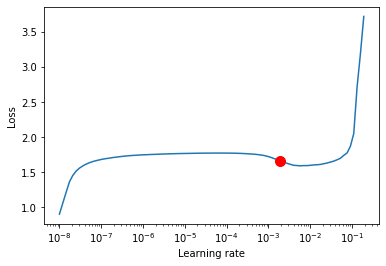

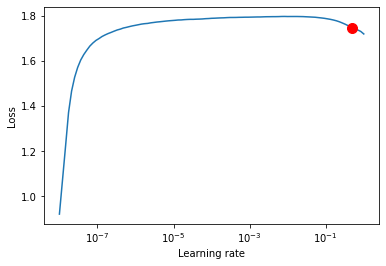

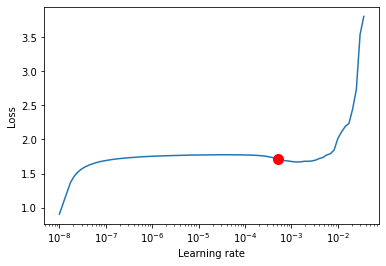

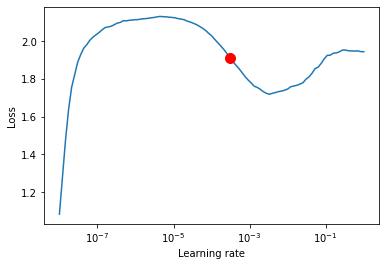

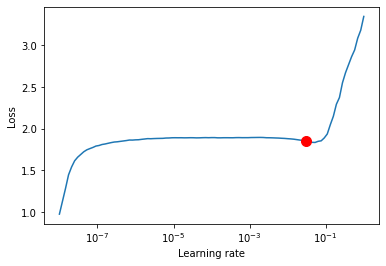

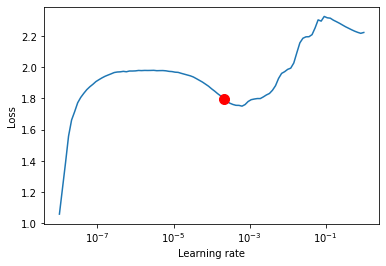

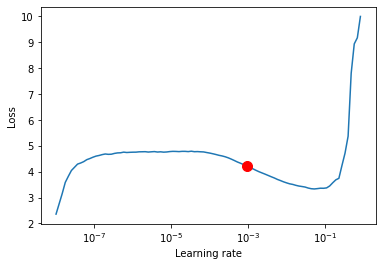

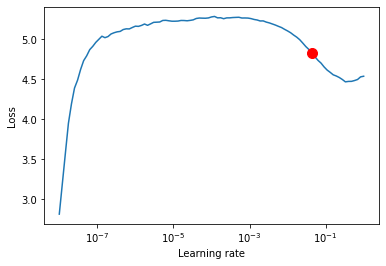

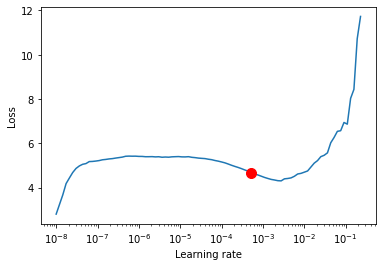

In [6]:
model_names = ["regnetz_c16", "resnet18", "efficientnet_b0"]

optimizer_names = ["ADAM", "SGD", "RMS"]

model_lr_rates = {}
num_classes = 6
BATCHSIZE = 256
for model_name in model_names:
    optim_lr_rates = {}
    for optimizer_name in optimizer_names:
        model = LitResnet(model_name=model_name, optim_name=optimizer_name)

        datamodule = IntelClassificationDataModule(data_dir=DIR, batch_size=BATCHSIZE)

        trainer = pl.Trainer(
                    limit_val_batches=PERCENT_VALID_EXAMPLES,
                    enable_checkpointing=False,
                    auto_lr_find=False,
                    accelerator="auto",
                    max_epochs=EPOCHS,
                )
        lr_finder = trainer.tuner.lr_find(model,datamodule)

        model.hparams.lr = lr_finder.suggestion()
        print("#########################")
        print(f'Auto-find model LR is:\n [Model Name: {model_name}, Optimizer Name: {optimizer_name}, Best Lr: {model.hparams.lr} ]')
        print("#############################")
        
        # append in dict
        optim_lr_rates[optimizer_name] = model.hparams.lr
        fig = lr_finder.plot(suggest=True)
    
    # append in model_dict
    model_lr_rates[model_name] = optim_lr_rates
    
print(model_lr_rates)
with open('lr_config.txt', 'w') as f:
    f.write(str(model_lr_rates))

In [7]:
BATCHSIZE = 256

In [8]:
model_names = list(model_lr_rates.keys())
for model_name in  model_names:
    for optimizer_name, lr in model_lr_rates[model_name].items():
        model = LitResnet(model_name=model_name, optim_name=optimizer_name)

        datamodule = IntelClassificationDataModule(data_dir=DIR, batch_size=BATCHSIZE)

        tb_logger = pl_loggers.TensorBoardLogger(save_dir="lr_logs")
        trainer = pl.Trainer(
                    logger=tb_logger,
                    limit_val_batches=PERCENT_VALID_EXAMPLES,
                    enable_checkpointing=False,
                    auto_lr_find=False,
                    accelerator="auto",
                    max_epochs=EPOCHS,
                )
        model.hparams.lr = float(lr)
        hyperparameters = dict(model_name=model_name, optimizer_name=optimizer_name, learning_rate= lr)
        trainer.logger.log_hyperparams(hyperparameters)
        print(f":: Training {model_name} with optim: {optimizer_name} and lr: {lr}")
        trainer.fit(model, datamodule)

:: Training regnetz_c16 with optim: ADAM and lr: 0.0019054607179632484


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

:: Training regnetz_c16 with optim: SGD and lr: 0.47863009232263803


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

:: Training regnetz_c16 with optim: RMS and lr: 0.0005248074602497723


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

:: Training resnet18 with optim: ADAM and lr: 0.0003019951720402019


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

:: Training resnet18 with optim: SGD and lr: 0.030199517204020192


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

:: Training resnet18 with optim: RMS and lr: 0.0002089296130854041


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

:: Training efficientnet_b0 with optim: ADAM and lr: 0.0009120108393559097


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

:: Training efficientnet_b0 with optim: SGD and lr: 0.04365158322401657


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

:: Training efficientnet_b0 with optim: RMS and lr: 0.0005248074602497723


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [9]:
# datamodule = IntelClassificationDataModule(data_dir=DIR, batch_size=BATCHSIZE)
# model = LitResnet(model_name="resnet18", optim_name="ADAM")

# # finds learning rate automatically
# # sets hparams.lr or hparams.learning_rate to that learning rate
# trainer = pl.Trainer(auto_lr_find=True)

# trainer.tune(model)

In [10]:
avail_pretrained_models = timm.list_models("efficientnet*",pretrained=True)
avail_pretrained_models

['efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b3',
 'efficientnet_b3_pruned',
 'efficientnet_b4',
 'efficientnet_el',
 'efficientnet_el_pruned',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_es_pruned',
 'efficientnet_lite0',
 'efficientnetv2_rw_m',
 'efficientnetv2_rw_s',
 'efficientnetv2_rw_t']

In [11]:
avail_pretrained_models = timm.list_models("regnet*",pretrained=True)
avail_pretrained_models

['regnetv_040',
 'regnetv_064',
 'regnetx_002',
 'regnetx_004',
 'regnetx_006',
 'regnetx_008',
 'regnetx_016',
 'regnetx_032',
 'regnetx_040',
 'regnetx_064',
 'regnetx_080',
 'regnetx_120',
 'regnetx_160',
 'regnetx_320',
 'regnety_002',
 'regnety_004',
 'regnety_006',
 'regnety_008',
 'regnety_016',
 'regnety_032',
 'regnety_040',
 'regnety_064',
 'regnety_080',
 'regnety_120',
 'regnety_160',
 'regnety_320',
 'regnetz_040',
 'regnetz_040h',
 'regnetz_b16',
 'regnetz_c16',
 'regnetz_c16_evos',
 'regnetz_d8',
 'regnetz_d8_evos',
 'regnetz_d32',
 'regnetz_e8']

In [12]:
import torch
print(torch.cuda.device_count())

1


In [13]:
from optuna.integration import PyTorchLightningPruningCallback


In [14]:
BATCHSIZE = 128
model_names = ["resnet18", "efficientnet_b0", "regnetz_c16"]
optimizer_names = ["ADAM", "SGD", "RMS"]
for model_name in model_names:
    for optimizer_name in optimizer_names:
        def objective(trial: optuna.trial.Trial) -> float:
            lr = float(trial.suggest_loguniform("lr", 1e-5, 1e-3))
            print("Trail with : \n")
            print("lr_rate:"+str(lr)+" model name: "+model_name+" optimizer name: "+optimizer_name)
            print("=========================================")
            model = LitResnet(model_name=model_name, optim_name=optimizer_name, lr=lr)

            datamodule = IntelClassificationDataModule(data_dir=DIR, batch_size=BATCHSIZE)

            tb_logger = pl_loggers.TensorBoardLogger(save_dir="logs")
            trainer = pl.Trainer(
                logger=tb_logger,
                limit_val_batches=PERCENT_VALID_EXAMPLES,
                enable_checkpointing=False,
                accelerator="auto",
                max_epochs=EPOCHS,
                callbacks=[PyTorchLightningPruningCallback(trial, monitor="train/acc")],
            )
            hyperparameters = dict(model_name=model_name, optimizer_name=optimizer_name, learning_rate=lr)
            trainer.logger.log_hyperparams(hyperparameters)
            trainer.fit(model, datamodule=datamodule)

            return trainer.callback_metrics["val/acc"].item()



        pruner: optuna.pruners.BasePruner = (optuna.pruners.MedianPruner())

        study = optuna.create_study(direction="maximize", pruner=pruner)
        study.optimize(objective, n_trials=150, timeout=250, n_jobs=2)

        pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
        complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

        print("Study statistics: ")
        print("  Number of finished trials: ", len(study.trials))
        print("  Number of pruned trials: ", len(pruned_trials))
        print("  Number of complete trials: ", len(complete_trials))
        print("Number of finished trials: {}".format(len(study.trials)))

        print("Best trial:")
        trial = study.best_trial

        print("  Value: {}".format(trial.value))

        print("Trail with : \n")
        print("=========================================")
        print("  Params: ")
        for key, value in trial.params.items():
            print("    {}: {}".format(key, value))



[I 2023-01-27 10:37:04,742] A new study created in memory with name: no-name-62df8bf0-2bfb-43c9-b292-39f32dd66d0a


Trail with : 

lr_rate:1.5387014391610225e-05 model name: resnet18 optimizer name: ADAM
Trail with : 

lr_rate:0.0005573000770544228 model name: resnet18 optimizer name: ADAM


/opt/conda/lib/python3.7/site-packages/optuna/study/study.py:397: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  FutureWarning,


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/integration/pytorch_lightning.py:52: UserWarning: The metric 'train/acc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)


Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-01-27 10:55:46,347] Trial 1 finished with value: 0.6640625 and parameters: {'lr': 0.0005573000770544228}. Best is trial 1 with value: 0.6640625.
[I 2023-01-27 10:55:49,263] Trial 0 finished with value: 0.69140625 and parameters: {'lr': 1.5387014391610225e-05}. Best is trial 0 with value: 0.69140625.
[I 2023-01-27 10:55:49,267] A new study created in memory with name: no-name-0aee7a7a-84b3-4a47-a728-3205710c2631
/opt/conda/lib/python3.7/site-packages/optuna/study/study.py:397: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  FutureWarning,


Study statistics: 
  Number of finished trials:  2
  Number of pruned trials:  0
  Number of complete trials:  2
Number of finished trials: 2
Best trial:
  Value: 0.69140625
Trail with : 

  Params: 
    lr: 1.5387014391610225e-05
Trail with : 

lr_rate:0.00010870808493082362 model name: resnet18 optimizer name: SGD
Trail with : 

lr_rate:0.00018685904555617726 model name: resnet18 optimizer name: SGD


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/integration/pytorch_lightning.py:52: UserWarning: The metric 'train/acc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)


Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-01-27 11:13:20,298] Trial 0 finished with value: 0.19140625 and parameters: {'lr': 0.00010870808493082362}. Best is trial 0 with value: 0.19140625.
[I 2023-01-27 11:13:22,622] Trial 1 finished with value: 0.20703125 and parameters: {'lr': 0.00018685904555617726}. Best is trial 1 with value: 0.20703125.
[I 2023-01-27 11:13:22,625] A new study created in memory with name: no-name-040ae6f0-a45f-4a82-8393-28a17a64d118
/opt/conda/lib/python3.7/site-packages/optuna/study/study.py:397: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  FutureWarning,


Study statistics: 
  Number of finished trials:  2
  Number of pruned trials:  0
  Number of complete trials:  2
Number of finished trials: 2
Best trial:
  Value: 0.20703125
Trail with : 

  Params: 
    lr: 0.00018685904555617726
Trail with : 

lr_rate:0.0002952612309453061 model name: resnet18 optimizer name: RMS
Trail with : 

lr_rate:1.6400594029743098e-05 model name: resnet18 optimizer name: RMS


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/integration/pytorch_lightning.py:52: UserWarning: The metric 'train/acc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)


Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-01-27 11:30:42,246] Trial 1 finished with value: 0.66796875 and parameters: {'lr': 1.6400594029743098e-05}. Best is trial 1 with value: 0.66796875.
[I 2023-01-27 11:30:42,353] Trial 0 finished with value: 0.6328125 and parameters: {'lr': 0.0002952612309453061}. Best is trial 1 with value: 0.66796875.
[I 2023-01-27 11:30:42,358] A new study created in memory with name: no-name-fb3e7734-9f7b-485d-b2e5-97413dc6d002
/opt/conda/lib/python3.7/site-packages/optuna/study/study.py:397: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  FutureWarning,


Study statistics: 
  Number of finished trials:  2
  Number of pruned trials:  0
  Number of complete trials:  2
Number of finished trials: 2
Best trial:
  Value: 0.66796875
Trail with : 

  Params: 
    lr: 1.6400594029743098e-05
Trail with : 

lr_rate:0.00017666411213203964 model name: efficientnet_b0 optimizer name: ADAM
Trail with : 

lr_rate:0.0006063137693138185 model name: efficientnet_b0 optimizer name: ADAM


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/integration/pytorch_lightning.py:52: UserWarning: The metric 'train/acc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)


Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-01-27 11:48:46,894] Trial 0 finished with value: 0.69140625 and parameters: {'lr': 0.00017666411213203964}. Best is trial 0 with value: 0.69140625.
[I 2023-01-27 11:48:47,822] Trial 1 finished with value: 0.74609375 and parameters: {'lr': 0.0006063137693138185}. Best is trial 1 with value: 0.74609375.
[I 2023-01-27 11:48:47,826] A new study created in memory with name: no-name-4b205f4b-604a-44b0-b4da-b77b7a10530e
/opt/conda/lib/python3.7/site-packages/optuna/study/study.py:397: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  FutureWarning,


Study statistics: 
  Number of finished trials:  2
  Number of pruned trials:  0
  Number of complete trials:  2
Number of finished trials: 2
Best trial:
  Value: 0.74609375
Trail with : 

  Params: 
    lr: 0.0006063137693138185
Trail with : 

lr_rate:6.874085976655349e-05 model name: efficientnet_b0 optimizer name: SGD
Trail with : 

lr_rate:1.5664417990581798e-05 model name: efficientnet_b0 optimizer name: SGD


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/integration/pytorch_lightning.py:52: UserWarning: The metric 'train/acc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)


Training: 0it [00:00, ?it/s]

Training: 0it [00:01, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-01-27 12:06:29,660] Trial 0 finished with value: 0.125 and parameters: {'lr': 6.874085976655349e-05}. Best is trial 0 with value: 0.125.


Validation: 0it [00:00, ?it/s]

[I 2023-01-27 12:06:37,557] Trial 1 finished with value: 0.046875 and parameters: {'lr': 1.5664417990581798e-05}. Best is trial 0 with value: 0.125.
[I 2023-01-27 12:06:37,562] A new study created in memory with name: no-name-fb58b154-8504-4c63-9f8c-439082bb8648
/opt/conda/lib/python3.7/site-packages/optuna/study/study.py:397: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  FutureWarning,


Study statistics: 
  Number of finished trials:  2
  Number of pruned trials:  0
  Number of complete trials:  2
Number of finished trials: 2
Best trial:
  Value: 0.125
Trail with : 

  Params: 
    lr: 6.874085976655349e-05
Trail with : 

lr_rate:0.00019315582450289164 model name: efficientnet_b0 optimizer name: RMS
Trail with : 

lr_rate:0.00013983407816102637 model name: efficientnet_b0 optimizer name: RMS


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/integration/pytorch_lightning.py:52: UserWarning: The metric 'train/acc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)


Training: 0it [00:00, ?it/s]

Training: 0it [00:02, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-01-27 12:24:26,428] Trial 1 finished with value: 0.7734375 and parameters: {'lr': 0.00013983407816102637}. Best is trial 1 with value: 0.7734375.
[I 2023-01-27 12:24:27,992] Trial 0 finished with value: 0.7265625 and parameters: {'lr': 0.00019315582450289164}. Best is trial 1 with value: 0.7734375.
[I 2023-01-27 12:24:27,994] A new study created in memory with name: no-name-71f0f5d8-bc2e-4845-a953-1b64a6a3937a
/opt/conda/lib/python3.7/site-packages/optuna/study/study.py:397: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  FutureWarning,


Study statistics: 
  Number of finished trials:  2
  Number of pruned trials:  0
  Number of complete trials:  2
Number of finished trials: 2
Best trial:
  Value: 0.7734375
Trail with : 

  Params: 
    lr: 0.00013983407816102637
Trail with : 

lr_rate:0.0002909947375625543 model name: regnetz_c16 optimizer name: ADAM
Trail with : 

lr_rate:2.5645450084705335e-05 model name: regnetz_c16 optimizer name: ADAM


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/integration/pytorch_lightning.py:52: UserWarning: The metric 'train/acc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)


Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-01-27 12:43:53,119] Trial 1 finished with value: 0.7421875 and parameters: {'lr': 2.5645450084705335e-05}. Best is trial 1 with value: 0.7421875.
[I 2023-01-27 12:43:54,133] Trial 0 finished with value: 0.79296875 and parameters: {'lr': 0.0002909947375625543}. Best is trial 0 with value: 0.79296875.
[I 2023-01-27 12:43:54,139] A new study created in memory with name: no-name-faf2f7ae-3535-498c-99db-89f43421e88a
/opt/conda/lib/python3.7/site-packages/optuna/study/study.py:397: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  FutureWarning,


Study statistics: 
  Number of finished trials:  2
  Number of pruned trials:  0
  Number of complete trials:  2
Number of finished trials: 2
Best trial:
  Value: 0.79296875
Trail with : 

  Params: 
    lr: 0.0002909947375625543
Trail with : 

lr_rate:8.369667623162916e-05 model name: regnetz_c16 optimizer name: SGD
Trail with : 

lr_rate:0.0004802368002897056 model name: regnetz_c16 optimizer name: SGD


Sanity Checking: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/optuna/integration/pytorch_lightning.py:52: UserWarning: The metric 'train/acc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)


Training: 0it [00:00, ?it/s]

Training: 0it [00:02, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-01-27 13:03:09,647] Trial 1 finished with value: 0.12109375 and parameters: {'lr': 0.0004802368002897056}. Best is trial 1 with value: 0.12109375.
[I 2023-01-27 13:03:12,135] Trial 0 finished with value: 0.1796875 and parameters: {'lr': 8.369667623162916e-05}. Best is trial 0 with value: 0.1796875.
[I 2023-01-27 13:03:12,142] A new study created in memory with name: no-name-b57be76c-224d-4148-9f3a-31053b7b10a8
/opt/conda/lib/python3.7/site-packages/optuna/study/study.py:397: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  FutureWarning,


Study statistics: 
  Number of finished trials:  2
  Number of pruned trials:  0
  Number of complete trials:  2
Number of finished trials: 2
Best trial:
  Value: 0.1796875
Trail with : 

  Params: 
    lr: 8.369667623162916e-05
Trail with : 

lr_rate:0.0005613688007786477 model name: regnetz_c16 optimizer name: RMS
Trail with : 

lr_rate:1.8975569906975162e-05 model name: regnetz_c16 optimizer name: RMS


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/optuna/integration/pytorch_lightning.py:52: UserWarning: The metric 'train/acc' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)


Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2023-01-27 13:22:50,868] Trial 0 finished with value: 0.68359375 and parameters: {'lr': 0.0005613688007786477}. Best is trial 0 with value: 0.68359375.
[I 2023-01-27 13:22:51,625] Trial 1 finished with value: 0.7734375 and parameters: {'lr': 1.8975569906975162e-05}. Best is trial 1 with value: 0.7734375.


Study statistics: 
  Number of finished trials:  2
  Number of pruned trials:  0
  Number of complete trials:  2
Number of finished trials: 2
Best trial:
  Value: 0.7734375
Trail with : 

  Params: 
    lr: 1.8975569906975162e-05
